# Đồ họa thống kê Python

# Bài 3: Vẽ đường cong ROC cho bài toán Multiclasses

### BS. Lê Ngọc Khả Nhi

Trong bài thực hành hôm nay Nhi sẽ hướng dẫn các bạn sử dụng matplotlib và scikitlearn để vẽ đường cong ROC cho một bài toán phân loại nhiều lớp (Multiclass classification).

Trước hết, ta nhắc lại về ngữ pháp đồ họa của đường cong ROC: đây là một biểu đồ 2 chiều nhằm đánh giá hiệu năng của một hệ thống quyết định (mô hình phân loại). Biểu đồ này sử dụng hình họa là nét vẽ liên tục (line, path, step) kết nối tọa độ của tất cả cặp giá trị False positive rate (trục hoành) và True Positive rate (trục tung), tương ứng với những ngưỡng cắt (threshold, cut-off) khác nhau trên thang kết quả của probability scores (mà mô hình ước tính từ dữ liệu). Diện tích dưới đường cong ROC (AUC) được dùng như 1 tiêu chí đánh giá hiệu năng của mô hình.

Như vậy, để dựng một ROC curve, ở dữ liệu đầu vào ta cần 2 array giá trị FPR và TPR. 

Hàm roc_curve của module scikitlearn.metrics cung cấp cho ta FPR và TPR, với dữ liệu đầu vào là chuỗi giá trị dự báo và giá trị quan sát thực tế.

Sau đó ta chỉ cần dùng matplotlib để dựng biểu đồ ROC

Việc này khá dễ dàng cho bài toán nhị phân, tuy nhiên nếu ta muốn dựng n ROC curves cho riêng từng classe trong 1 bài toán phân loại multiclasses thì vấn đề sẽ phức tạp hơn:

Trước tiên, ta không thể sử dụng trực tiếp outcome mà phải dùng hàm label_binarize của module sklearn.preprocessing để encode lại outcome thành các chuỗi giá trị nhị phân cho mỗi class;

Sau đó ta sử dụng 1 vòng lặp để tính toán TPR và FPR riêng cho từng level của outcome

Cuối cùng, ta dùng 1 vòng lặp khác và cơ chế subplot của matplotlib để vẽ lần lượt nhiều ROC curves

Trong bài này, Nhi sẽ thêm vào 1 tính năng khác, đó là ước tính khoảng tin cậy của TPR, FPR, và AUC, dựa vào bootstrap và đưa những thông tin này lên biểu đồ sau cùng.

Ta sẽ minh họa bằng dataset iris trong chính scikitlearn:

In [52]:
from sklearn import datasets
from sklearn.preprocessing import label_binarize

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier

Đầu tiên, ta tải dataset iris, cắt ra 50% để dựng 1 mô hình cây phân loại, và dùng 50% để test

In [63]:
iris_X, iris_y = datasets.load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, 
                                                    test_size=0.5, 
                                                    random_state=123)

In [66]:
tree = DecisionTreeClassifier(max_depth = 2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
Nhi bắt đầu viết nội dung hàm vẽ nhiều ROC curves:

In [150]:
def multiclass_ROC(Model = None, X_test = None, y_test = None, labels = None, 
                   pal_dict = ['green','red','purple'],n_iter = 1000, vertical = True):
    
    '''
    Công dụng: vẽ nhiều ROC curves dựa vào TPR và FPR, kèm 95%CI bootstrap
    
    Arguments:
    Model = Mô hình multiclass classifier
    
    X_test = array dữ liệu đầu vào
    
    y_test = outcome thực tế
    
    labels = 1 list tên các labels thí dụ '['A', 'B', 'C']'
    
    pal_dict = 1 list danh sách các màu để tô cho từng label
    
    n_iter = số lượt bootstrap
    
    Kết quả xuất ra: Biểu đồ matplotlib hiển thị trong notebook, 
    và save lại dưới định dạng SVGcó độ phân giải 100 DPI
    '''
    
    # Bước 1: Chuẩn bị các parameter place holders cho bootstrap
    
    n_classes = len(labels)
    label_dict = dict(zip(range(n_classes),labels))
    
    y_roc = label_binarize(y_test, classes = list(range(n_classes)))
    y_score = Model.predict_proba(X_test)
    
    base_fpr_dict = dict()
    mean_tprs_dict = dict()
    mean_auc_dict = dict()
    std_auc_dict = dict()
    tprs_lower_dict = dict()
    tprs_upper_dict = dict()
    
    # Bước 2: Bootstrap và tính TPR, FNR, AUC cùng 95%CI
    
    for k in range(n_classes):
        
        tprs = []
        aucs = []
        base_fpr = np.linspace(0, 1, 101)
        
        rng_seed = 123
        rng = np.random.RandomState(rng_seed)
        
        for i in range(n_iter):
            # bootstrap by sampling with replacement on the prediction indices
            y_pred = y_score[:,k]
            y_true = y_roc[:,k]
            
            indices = rng.randint(0, len(y_pred), len(y_pred))
            if len(np.unique(y_true[indices])) < 2:
                continue
                
            fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
            
            roc_auc_i = auc(fpr, tpr)
            aucs.append(roc_auc_i)
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
        
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        mean_auc = auc(base_fpr, mean_tprs)
        std_auc = np.std(aucs)
        
        tprs_upper = np.minimum(mean_tprs + 1.645*std, 1)
        tprs_lower = mean_tprs - 1.645*std

        base_fpr_dict[k] = base_fpr
        mean_tprs_dict[k] = mean_tprs
        mean_auc_dict[k] = mean_auc
        std_auc_dict[k] = std_auc
        tprs_lower_dict[k] = tprs_lower
        tprs_upper_dict[k] = tprs_upper
        
    # Bước 3: Vẽ biểu đồ        
        
    if vertical:
        sub_row = n_classes*100 + 10
        
        plt.rcParams.update({'font.size': n_classes*4})
        plt.figure(figsize= (n_classes*1.5, n_classes*5), dpi = 100)
        
        for sr in range(n_classes):
            plt.subplot(sub_row + sr + 1)
            lw = 2
            
            plt.plot(base_fpr_dict[sr], 
                     mean_tprs_dict[sr],
                     lw = lw,
                     color = pal_dict[sr],
                     alpha = 0.8, 
                     label=f'ROC_AUC = {mean_auc_dict[sr]:.3} \n95%CI: {(mean_auc_dict[sr] - 1.645*std_auc_dict[sr]):.3} to {(mean_auc_dict[sr] + 1.645*std_auc_dict[sr]):.3}''')
            
            plt.fill_between(base_fpr_dict[sr], 
                     tprs_lower_dict[sr],
                     tprs_upper_dict[sr], 
                             color = pal_dict[sr], 
                             alpha = 0.2)
            
            plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
            
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Target: '+ label_dict[sr])
            plt.legend(loc="lower right")
            
    else:
        sub_row = 100 + 10*n_classes
        
        plt.rcParams.update({'font.size': n_classes*5})
        plt.figure(figsize= (n_classes*5, n_classes*1.5), dpi = 100)
        
        for sr in range(n_classes):
            plt.subplot(sub_row + sr + 1)
            lw = 2
            
            plt.plot(base_fpr_dict[sr], 
                     mean_tprs_dict[sr],
                     lw = lw,
                     color = pal_dict[sr],
                     alpha = 0.8, 
                     label=f'ROC_AUC = {mean_auc_dict[sr]:.3} \n95%CI: {(mean_auc_dict[sr] - 1.645*std_auc_dict[sr]):.3} to {(mean_auc_dict[sr] + 1.645*std_auc_dict[sr]):.3}''')
            
            plt.fill_between(base_fpr_dict[sr], 
                     tprs_lower_dict[sr],
                     tprs_upper_dict[sr], 
                             color = pal_dict[sr], 
                             alpha = 0.2)
            
            plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
            
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Target: '+ label_dict[sr])
            plt.legend(loc="lower right")
        
    plt.savefig('MultiROC_iris.svg')

Kết quả gần giống như thế này:

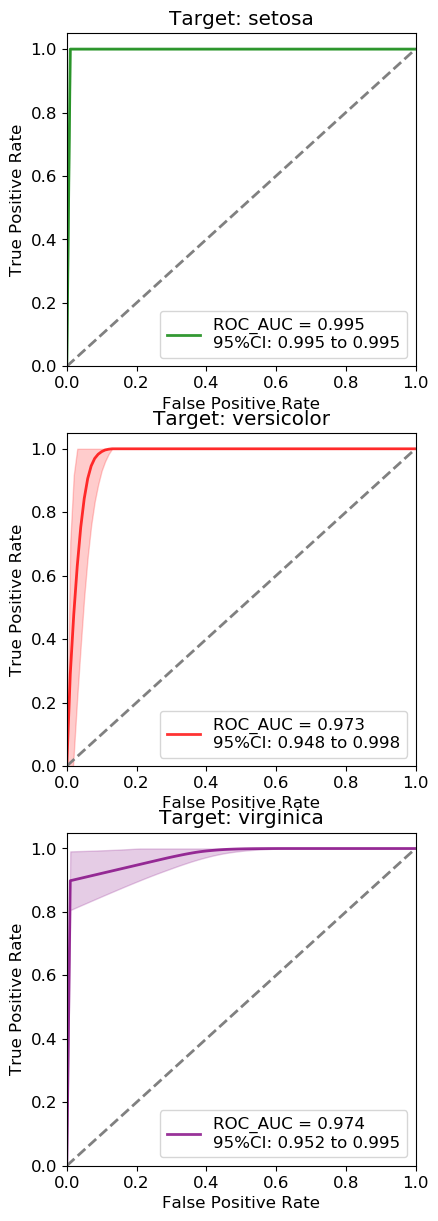

In [148]:
multiclass_ROC(Model = tree, X_test = X_test, y_test = y_test, 
               labels = ['setosa', 'versicolor', 'virginica'], 
               pal_dict = ['green','red','purple'],n_iter = 100)

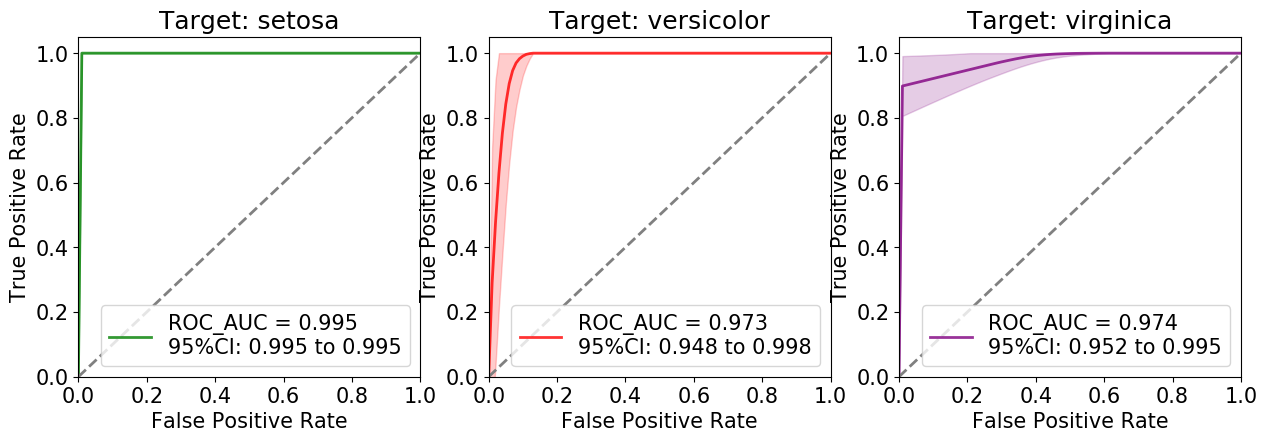

In [151]:
multiclass_ROC(Model = tree, X_test = X_test, y_test = y_test, 
               labels = ['setosa', 'versicolor', 'virginica'], 
               pal_dict = ['green','red','purple'],
               n_iter = 100, 
               vertical=False)

có 2 'Trick' ở đây , thứ nhất là tham số sub_row cho method subplot:

Khi ta set giá trị sub_row = 100 + 10 x n_classes, ta sẽ có 3 biểu đồ nằm ngang, vì kết quả sub_row = 130 (1 hàng, 3 cột)
Khi set sub_row = n_classes x 100 + 10, ta sẽ có biểu đồ dọc, vì kết quả sub_row = 310 (3 hàng, 1 cột)

Thứ 2 là điều chỉnh các tham số về font chữ, kích thước plot để có hiệu ứng thị giác tối ưu